In [203]:
import os
import os.path
import sys
import warnings

import gcsfs
import global_land_mask
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xesmf as xe
from google.cloud import storage
from zarr.convenience import consolidate_metadata
import cmocean
sys.path.insert(0, '../.')

warnings.filterwarnings('ignore')
plt.style.use('mpl20')

import gsw_xarray as gsw
import xarray as xr
import numpy as np
import os
import os.path
import sys
import warnings
from xclim.sdba.detrending import PolyDetrend
import cartopy.geodesic as cgd
import cartopy.crs as ccrs
import cartopy.feature as cpf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shapely
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import colors
from shapely import geometry

sys.path.insert(0, '../.')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

import xarray as xr
import numpy as np

In [204]:
def load_station(station: {}):
    f1 = f"{station['base_directory']}/{station['station_name']}_temp_salt.nc"
    f2 = f"{station['base_directory']}/{station['station_name']}_phyc.nc"
    f3 = f"{station['base_directory']}/{station['station_name']}_n2.nc"

    if os.path.exists(f1) and os.path.exists(f2) and os.path.exists(f3):
        ds1 = xr.open_dataset(f1)
        ds2 = xr.open_dataset(f2)
        ds3 = xr.open_dataset(f3)
        ds3 = ds3.transpose("time", "depth", "lat", "lon")
        print(f"Found station {station['station_name']}")
        return ds1, ds2, ds3
    else:
        return None, None, None

In [205]:
def create_profile_plot(ds1, ds2, ds3, station):
    
 
    # Scatterplots of Temperature and Salinity
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,6))
    x, y = np.meshgrid(ds1["time"].values, ds1["depth"].values)
 
    sc1 = ax1.contourf(x,y,ds1["thetao"].mean({"lat","lon"}).values.T, cmap='RdYlBu_r')
    sc2 = ax2.contourf(x,y,ds1["so"].mean({"lat","lon"}).values.T, cmap=cmocean.cm.haline)
    
    # Set axis limits
    max_depth=np.isnan(ds1["thetao"][0,:,0,0]).argmax()
    ax1.set_ylim(0,ds1["depth"][max_depth].values)  
    ax1.invert_yaxis() # Invert y axis
    ax1.set_xlim(ds1["time"][0],ds1["time"][-1]) 
  
    cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
    cbar.ax.set_ylabel('Temperature')
    cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
    cbar.ax.set_ylabel('Salinity')

    ax1.set_ylabel('Depth (m)')
    ax2.set_ylabel('Depth (m)')

    fig.suptitle(f"{station['station_name']}")
    fig.autofmt_xdate()
    fig.subplots_adjust(top=0.95)
    plt.show()
   # plotfile = "Figures/timeseries_{}.png".format(var_name)
   # plt.savefig(plotfile, dpi=200)
   # print(f"Saved timeseries to {plotfile}")

    fig, ax1 = plt.subplots(1,1, figsize=(14,6))
    
    x, y = np.meshgrid(ds2["time"].values, ds2["depth"].values)
    sc1 = ax1.contourf(x,y,ds2["phyc"].mean({"lat","lon"}, skipna=True).values.T, cmap=cmocean.cm.haline)
    
    # Set axis limits
    #max_depth=np.isnan(ds2["phyc"][1,:,0,0]).argmax()
    
    ax1.set_ylim(0,ds2["depth"][max_depth].values) 
    ax1.invert_yaxis() # Invert y axis
    ax1.set_xlim(ds2["time"][0],ds2["time"][-1]) 
  
    cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
    cbar.ax.set_ylabel('Total phytoplankton')
    ax1.set_ylabel('Depth (m)')
    
    fig.suptitle(f"{station['station_name']}")
    fig.autofmt_xdate()
    fig.subplots_adjust(top=0.95)
    plt.show()
    
    fig, ax1 = plt.subplots(1,1, figsize=(14,6))
    
    x, y = np.meshgrid(ds3["time"].values, ds3["depth"].values)
    sc1 = ax1.contourf(x,y,ds3["n2"].mean({"lat","lon"}, skipna=True).values, cmap=cmocean.cm.haline)
    
    # Set axis limits
    #max_depth=np.isnan(ds3["n2"][0,:,2,2]).argmax()
    ax1.set_ylim(0,ds3["depth"][max_depth].values)  
    ax1.invert_yaxis() # Invert y axis
    ax1.set_xlim(ds3["time"][0],ds3["time"][-1]) 
  
    cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
    cbar.ax.set_ylabel('N$^{2}$')
    ax1.set_ylabel('Depth (m)')
    
    fig.suptitle(f"{station['station_name']}")
    fig.autofmt_xdate()
    fig.subplots_adjust(top=0.95)
    plt.show()



In [206]:
def calculate_trend(da: xr.DataArray, var_name: str):
     # Make sure time is in one chunk
    da = da.chunk(chunks={'time':-1})

    # Create the detrending object
    det = PolyDetrend(group="time", degree=1, preserve_mean=True, kind="+")
    # Fitting returns a new object and computes the trend.
    fit = det.fit(da)
    # Return the trend
    return (da - fit.detrend(da)).to_dataset(name=f"trend_{var_name}") #.groupby("time.month").mean("time",
                                                                       #                          keep_attrs=True)

def create_trend_plot(ds1, ds2, ds3, station):

    ds1=ds1.mean({"lat","lon"}) #.resample(time="1D").mean()
    ds2=ds2.mean({"lat","lon"}) #.resample(time="1D").mean()
    ds3=ds3.mean({"lat","lon"}) #.resample(time="1D").mean()

    thetao_trend = calculate_trend(ds1["thetao"], "thetao")
    n2_trend = calculate_trend(ds3["n2"], "n2")

    ds1_mean = ds1.groupby("time.month").mean("time", keep_attrs=True)
    ds2_mean = ds2.groupby("time.month").mean("time", keep_attrs=True)
    ds3_mean = ds3.groupby("time.month").mean("time", keep_attrs=True)
    all_plots=True
    if all_plots==True:
        # Trend plots temperature and salinity
        fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(14,6))
        x, y = np.meshgrid(ds1_mean["month"].values, ds1_mean["depth"].values)

        sc1 = ax1.contourf(x,y,ds1_mean["thetao"].values.T, cmap='RdYlBu_r')
        _ = ax1.contour(x,y, ds1_mean["thetao"].values.T, colors='black', linewidth=0.01)
        sc2 = ax2.contourf(x,y,ds1_mean["so"].values.T, cmap=cmocean.cm.haline)
        _ = ax2.contour(x,y, ds1_mean["so"].values.T, colors='black', linewidth=0.01)

        # Set axis limits
        max_depth=np.isnan(ds1_mean["thetao"][0,:]).argmax()
        ax1.set_ylim(0,200) #ds1_mean["depth"][max_depth].values)
        ax1.invert_yaxis() # Invert y axis
        ax1.set_xlim(ds1_mean["month"][0],ds1_mean["month"][-1])

        cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
        cbar.ax.set_ylabel('Temperature')
        cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
        cbar.ax.set_ylabel('Salinity')

        ax1.set_ylabel('Depth (m)')
        ax2.set_ylabel('Depth (m)')

        fig.suptitle(f"{station['station_name']}")
        fig.autofmt_xdate()
        fig.subplots_adjust(top=0.95)
        plotfile = f"{station['base_directory']}/Figures/{station['station_name']}_thetao_salt.png"
        plt.savefig(plotfile, dpi=200)
        print(f"Saved timeseries to {plotfile}")

        # Phyc and N2 climatology
        fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(14,6))
        x, y = np.meshgrid(ds2_mean["month"].values, ds2_mean["depth"].values)
        x2, y2 = np.meshgrid(ds3_mean["month"].values, ds3_mean["depth"].values)

        sc1 = ax1.contourf(x,y,ds2_mean["phyc"].values.T, cmap='RdYlBu_r')
        _ = ax1.contour(x,y, ds2_mean["phyc"].values.T, colors='black', linewidth=0.01)
        sc2 = ax2.contourf(x2,y2,ds3_mean["n2"].values.T, cmap=cmocean.cm.haline)
        _ = ax2.contour(x2,y2, ds3_mean["n2"].values.T, colors='black', linewidth=0.01)

        ax1.set_ylim(0,200) #ds1_mean["depth"][max_depth].values)
        ax1.invert_yaxis() # Invert y axis
        ax1.set_xlim(ds1_mean["month"][0],ds1_mean["month"][-1])

        cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
        cbar.ax.set_ylabel('Phyc')
        cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
        cbar.ax.set_ylabel('N2')

        ax1.set_ylabel('Depth (m)')
        ax2.set_ylabel('Depth (m)')

        fig.suptitle(f"{station['station_name']}")
        fig.autofmt_xdate()
        fig.subplots_adjust(top=0.95)
      #  plt.show()
        plotfile = f"{station['base_directory']}/Figures/{station['station_name']}_n2_phyc.png"
        plt.savefig(plotfile, dpi=200)
        print(f"Saved timeseries to {plotfile}")

    fig, axes = plt.subplots(1,2, sharey=True, sharex=False, figsize=(14,6))

    decadal_trend_change = thetao_trend["trend_thetao"].isel(time=323).values  - thetao_trend["trend_thetao"].isel\
        (time=204).values
    decadal_trend_change2 = thetao_trend["trend_thetao"].isel(time=323).values  - thetao_trend["trend_thetao"].isel\
        (time=84).values

    axes[0].plot(decadal_trend_change,thetao_trend["depth"]
                       .values,
                       c="tab:red",
                       label="2020-2010",
                   linewidth=2)
    axes[0].plot(decadal_trend_change2,thetao_trend["depth"]
                       .values,
                       c="tab:green",
                       label="2020-2000",
                   linewidth=2)
    axes[0].legend()
    decadal_trend_change = n2_trend["trend_n2"].isel(time=323).values  - n2_trend["trend_n2"].isel\
        (time=204).values
    axes[1].plot(decadal_trend_change,n2_trend["depth"].values, c="tab:red",label="2020-2010",
                   linewidth=2)

    decadal_trend_change = n2_trend["trend_n2"].isel(time=323).values  - n2_trend["trend_n2"].isel\
        (time=84).values
    axes[1].plot(decadal_trend_change,n2_trend["depth"].values, c="tab:green",label="2020-2000",
                   linewidth=2)
    axes[1].legend()

    axes[0].set_ylim(0,200) #thetao_trend["depth"][max_depth].values)
    axes[0].invert_yaxis() # Invert y axis
    axes[0].set_ylabel('Depth (m)')

    fig.suptitle(f"{station['station_name']}")
    fig.autofmt_xdate()
    fig.subplots_adjust(top=0.95)
    plotfile = f"{station['base_directory']}/Figures/{station['station_name']}_trend_thetao_n2.png"
    plt.savefig(plotfile, dpi=200)
    print(f"Saved timeseries to {plotfile}")




In [ ]:
                                                                 #                          keep_attrs=True)
def create_trend_plot2(ds1, ds2, ds3, station):

    ds1=ds1.mean({"lat","lon"}) #.resample(time="1D").mean()
    ds2=ds2.mean({"lat","lon"}) #.resample(time="1D").mean()
    ds3=ds3.mean({"lat","lon"}) #.resample(time="1D").mean()

    thetao_trend = calculate_trend(ds1["thetao"], "thetao")
    n2_trend = calculate_trend(ds3["n2"], "n2")

    ds1_mean = ds1.groupby("time.month").mean("time", keep_attrs=True)
    ds2_mean = ds2.groupby("time.month").mean("time", keep_attrs=True)
    ds3_mean = ds3.groupby("time.month").mean("time", keep_attrs=True)
    all_plots=True
    if all_plots==True:
        # Trend plots temperature and salinity
        fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(14,6))
        x, y = np.meshgrid(ds1_mean["month"].values, ds1_mean["depth"].values)

        sc1 = ax1.contourf(x,y,ds1_mean["thetao"].values.T, cmap='RdYlBu_r')
        _ = ax1.contour(x,y, ds1_mean["thetao"].values.T, colors='black', linewidth=0.01)
        sc2 = ax2.contourf(x,y,ds1_mean["so"].values.T, cmap=cmocean.cm.haline)
        _ = ax2.contour(x,y, ds1_mean["so"].values.T, colors='black', linewidth=0.01)

        # Set axis limits
        max_depth=np.isnan(ds1_mean["thetao"][0,:]).argmax()
        ax1.set_ylim(0,200) #ds1_mean["depth"][max_depth].values)
        ax1.invert_yaxis() # Invert y axis
        ax1.set_xlim(ds1_mean["month"][0],ds1_mean["month"][-1])

        cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
        cbar.ax.set_ylabel('Temperature')
        cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
        cbar.ax.set_ylabel('Salinity')

        ax1.set_ylabel('Depth (m)')
        ax2.set_ylabel('Depth (m)')

        fig.suptitle(f"{station['station_name']}")
        fig.autofmt_xdate()
        fig.subplots_adjust(top=0.95)
        plotfile = f"{station['base_directory']}/Figures/{station['station_name']}_thetao_salt.png"
        plt.savefig(plotfile, dpi=200)
        print(f"Saved timeseries to {plotfile}")

        # Phyc and N2 climatology
        fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(14,6))
        x, y = np.meshgrid(ds2_mean["month"].values, ds2_mean["depth"].values)
        x2, y2 = np.meshgrid(ds3_mean["month"].values, ds3_mean["depth"].values)

        sc1 = ax1.contourf(x,y,ds2_mean["phyc"].values.T, cmap='RdYlBu_r')
        _ = ax1.contour(x,y, ds2_mean["phyc"].values.T, colors='black', linewidth=0.01)
        sc2 = ax2.contourf(x2,y2,ds3_mean["n2"].values.T, cmap=cmocean.cm.haline)
        _ = ax2.contour(x2,y2, ds3_mean["n2"].values.T, colors='black', linewidth=0.01)

        ax1.set_ylim(0,200) #ds1_mean["depth"][max_depth].values)
        ax1.invert_yaxis() # Invert y axis
        ax1.set_xlim(ds1_mean["month"][0],ds1_mean["month"][-1])

        cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
        cbar.ax.set_ylabel('Phyc')
        cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
        cbar.ax.set_ylabel('N2')

        ax1.set_ylabel('Depth (m)')
        ax2.set_ylabel('Depth (m)')

        fig.suptitle(f"{station['station_name']}")
        fig.autofmt_xdate()
        fig.subplots_adjust(top=0.95)
      #  plt.show()
        plotfile = f"{station['base_directory']}/Figures/{station['station_name']}_n2_phyc.png"
        plt.savefig(plotfile, dpi=200)
        print(f"Saved timeseries to {plotfile}")

    fig, axes = plt.subplots(1,2, sharey=True, sharex=False, figsize=(14,6))

    decadal_trend_change = thetao_trend["trend_thetao"].isel(time=323).values  - thetao_trend["trend_thetao"].isel\
        (time=204).values
    decadal_trend_change2 = thetao_trend["trend_thetao"].isel(time=323).values  - thetao_trend["trend_thetao"].isel\
        (time=84).values

    axes[0].plot(decadal_trend_change,thetao_trend["depth"]
                       .values,
                       c="tab:red",
                       label="2020-2010",
                   linewidth=2)
    axes[0].plot(decadal_trend_change2,thetao_trend["depth"]
                       .values,
                       c="tab:green",
                       label="2020-2000",
                   linewidth=2)
    axes[0].legend()
    decadal_trend_change = n2_trend["trend_n2"].isel(time=323).values  - n2_trend["trend_n2"].isel\
        (time=204).values
    axes[1].plot(decadal_trend_change,n2_trend["depth"].values, c="tab:red",label="2020-2010",
                   linewidth=2)

    decadal_trend_change = n2_trend["trend_n2"].isel(time=323).values  - n2_trend["trend_n2"].isel\
        (time=84).values
    axes[1].plot(decadal_trend_change,n2_trend["depth"].values, c="tab:green",label="2020-2000",
                   linewidth=2)
    axes[1].legend()

    axes[0].set_ylim(0,200) #thetao_trend["depth"][max_depth].values)
    axes[0].invert_yaxis() # Invert y axis
    axes[0].set_ylabel('Depth (m)')

    fig.suptitle(f"{station['station_name']}")
    fig.autofmt_xdate()
    fig.subplots_adjust(top=0.95)
    plotfile = f"{station['base_directory']}/Figures/{station['station_name']}_trend_thetao_n2.png"
    plt.savefig(plotfile, dpi=200)
    print(f"Saved timeseries to {plotfile}")




   Unnamed: 0       Site     Location   Latitude  Longitude    ID
0           0      Adams  New Zealand -50.902700  166.00180  SID0
1           1  Admiralty   Antarctica -62.177800  -58.44470  SID1
2           2     Aiktak          USA  54.188600 -164.84000  SID2
3           3   Alcatraz          USA  37.826670 -122.42333  SID3
4           4  Amsterdam       France -37.816667   77.53333  SID4
Found station Adams
Station: Adams latitude: -50.9027 longitude: 166.0018
Saved timeseries to /Users/trondkr/Library/CloudStorage/OneDrive-Personal/PycharmProjects/NSF_stratification/data/NetCDF/Figures/Adams_thetao_salt.png
Saved timeseries to /Users/trondkr/Library/CloudStorage/OneDrive-Personal/PycharmProjects/NSF_stratification/data/NetCDF/Figures/Adams_n2_phyc.png
Saved timeseries to /Users/trondkr/Library/CloudStorage/OneDrive-Personal/PycharmProjects/NSF_stratification/data/NetCDF/Figures/Adams_trend_thetao_n2.png
Could not find files for Admiralty
Could not find files for Aiktak
Could not 

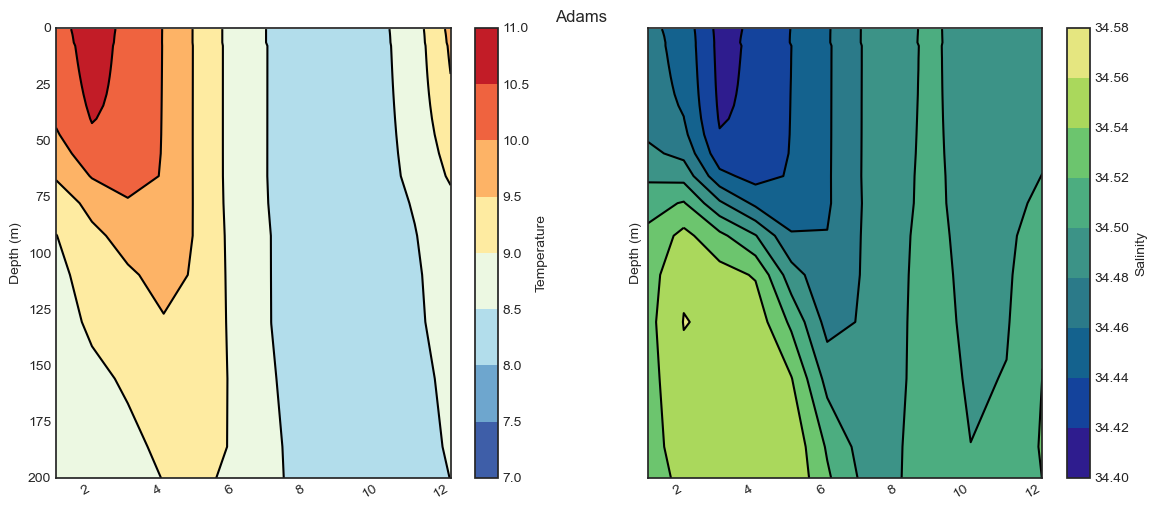

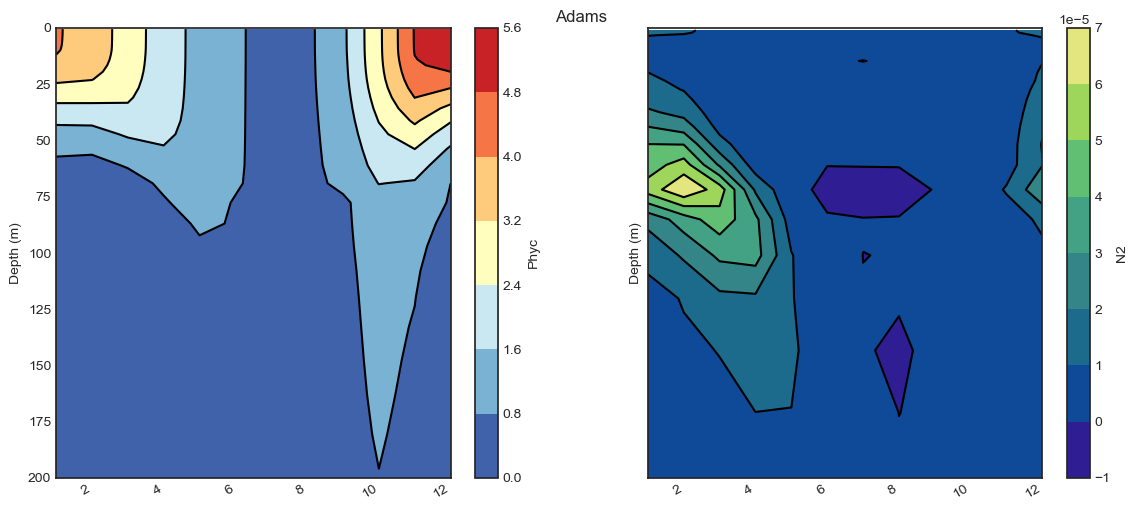

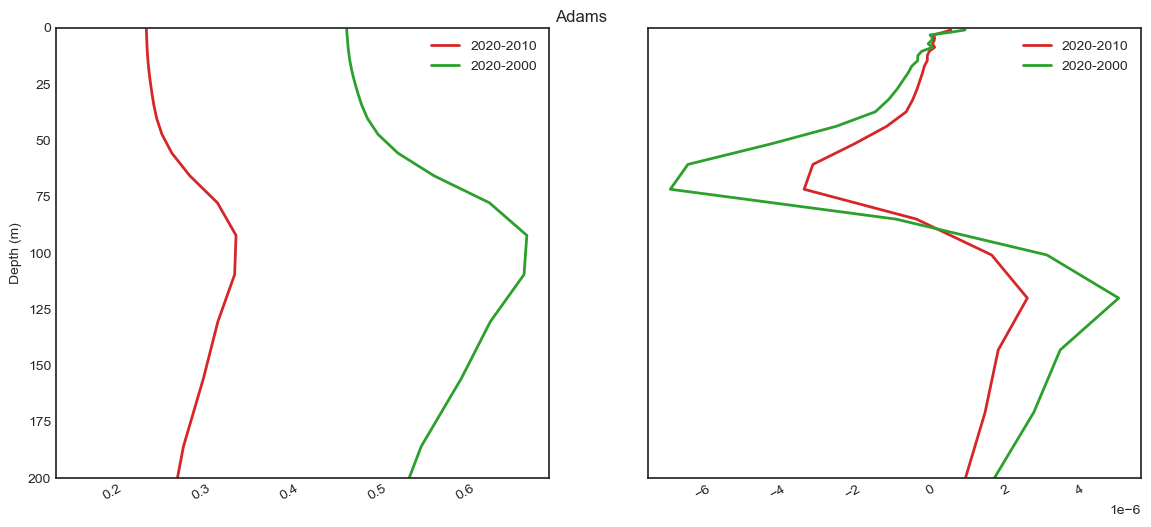

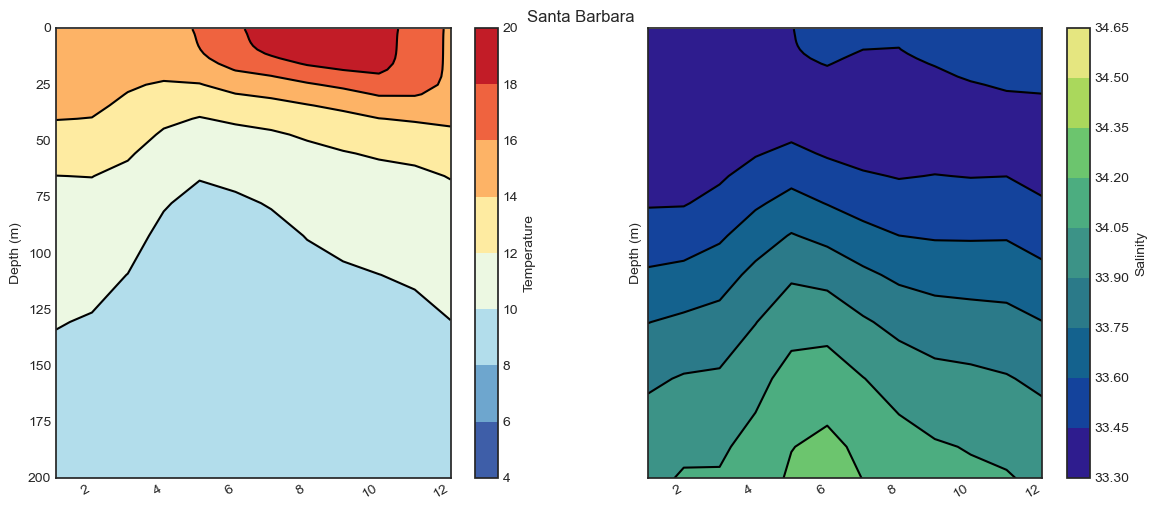

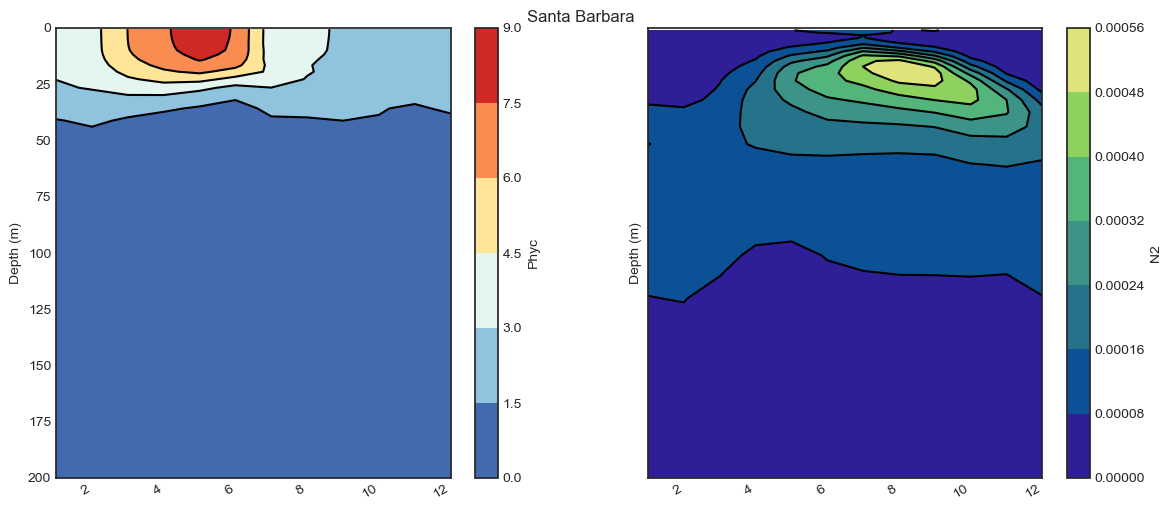

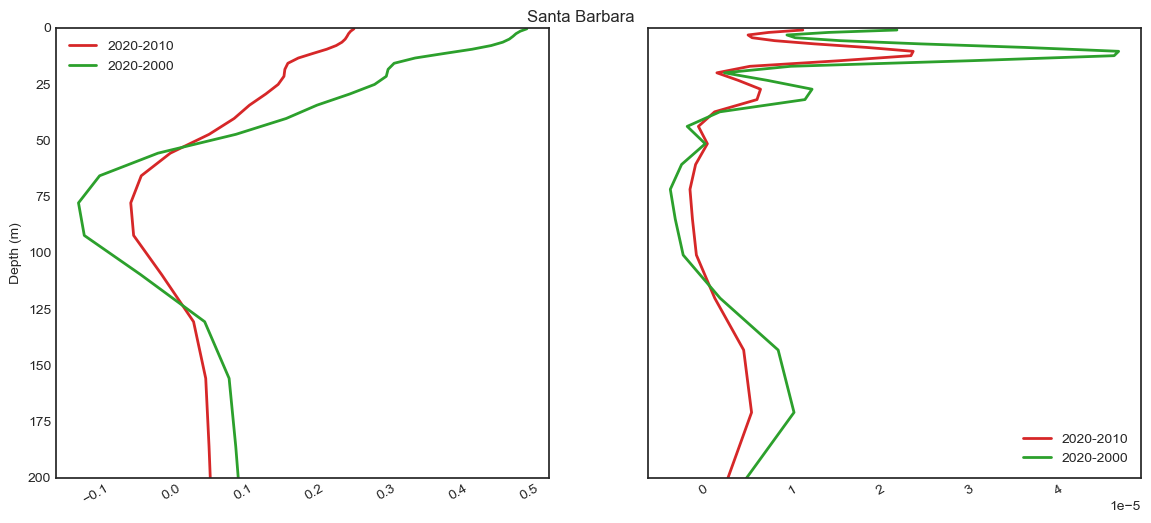

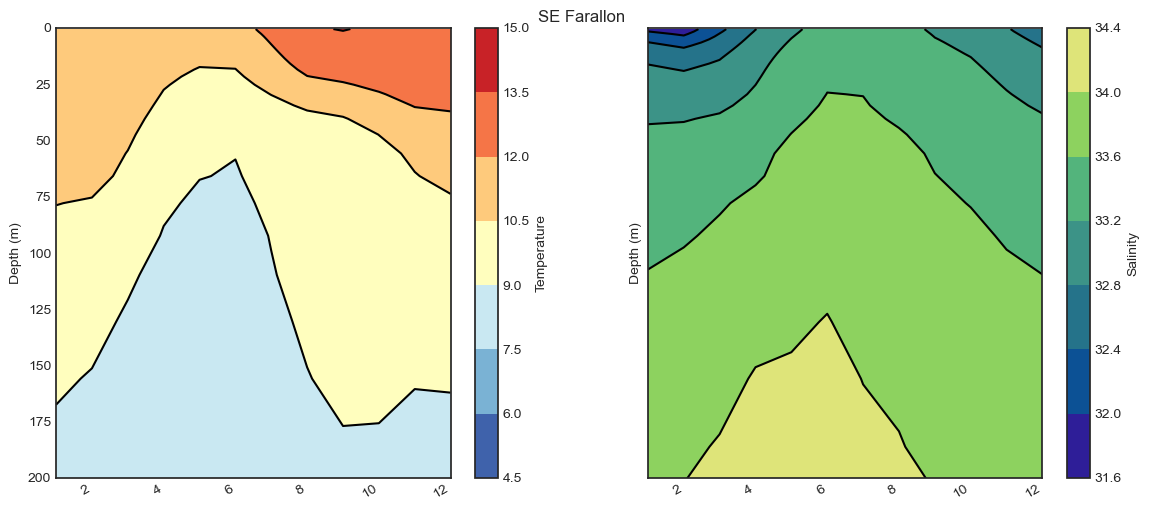

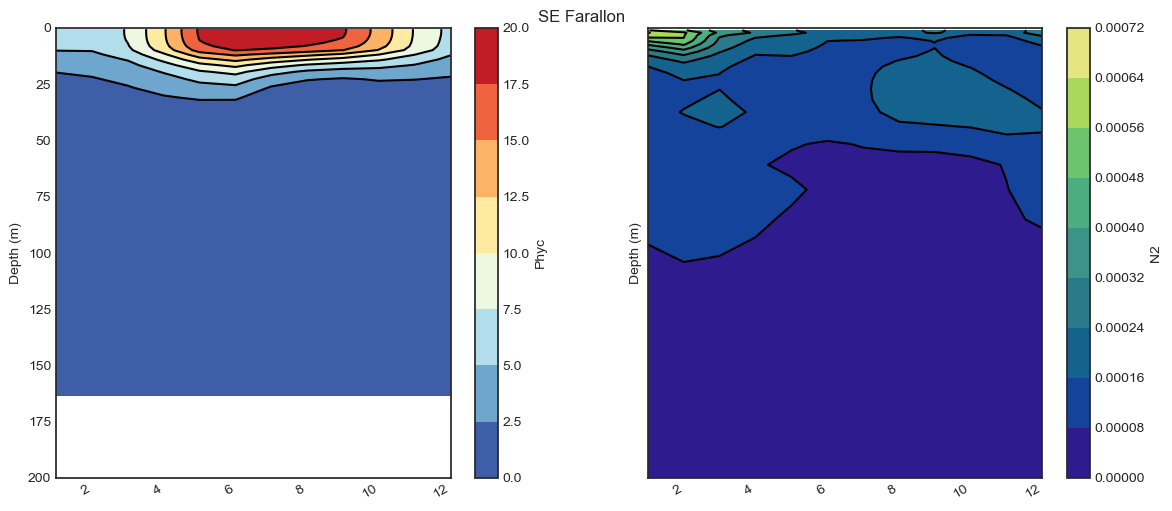

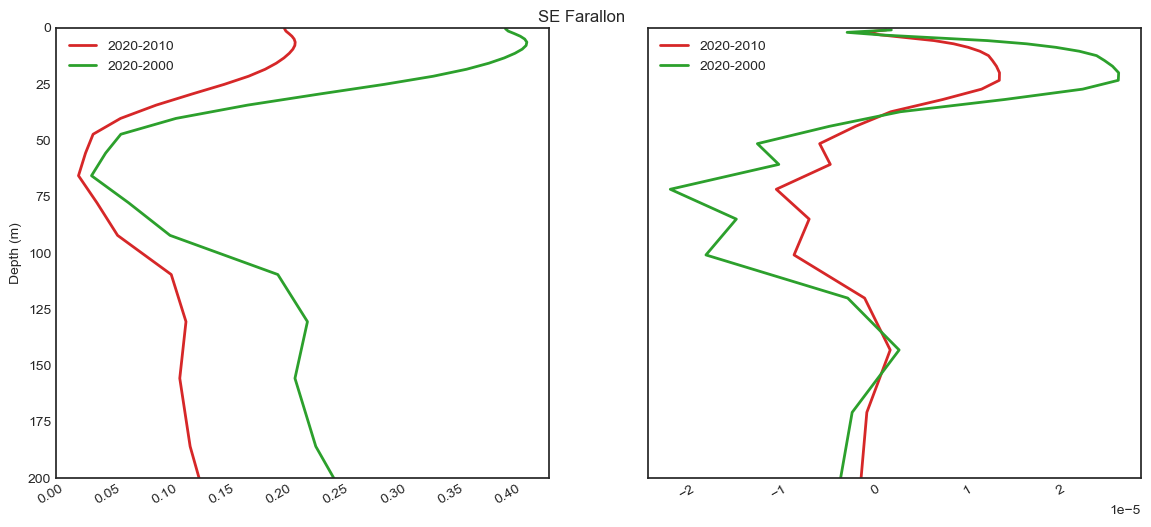

In [207]:
infile = "site_coordinateswID_111622_21Nov2022.csv"
df = pd.read_csv(infile, header=[0])
print(df.head())
base_directory = "/Users/trondkr/Library/CloudStorage/OneDrive-Personal/PycharmProjects/NSF_stratification/data/NetCDF"
if not os.path.exists(base_directory):
    os.makedirs(base_directory, exist_ok=True)
if not os.path.exists(f"{base_directory}/Figures"):
    os.makedirs(f"{base_directory}/Figures", exist_ok=True)

stations = {}
maxindex = 90
# Prepare all the stations
for index, row in df.iterrows():

    st_lat = float(row.Latitude)
    st_lon = float(row.Longitude)

    station = {"station_name": row.Site,
               "lat": st_lat,
               "lon": st_lon,
               "ID": row.ID,
               "base_directory": base_directory}
    (ds1, ds2, ds3) = load_station(station)
    if ds1 is not None:
        print(f"Station: {row.Site} latitude: {st_lat} longitude: {st_lon}")
       # create_profile_plot(ds1, ds2, ds3, station)
        create_trend_plot(ds1, ds2, ds3, station)
    else:
        print(f"Could not find files for {row.Site}")
    if index == maxindex:
        break
